<a href="https://colab.research.google.com/github/N3wBaz/ml-intro/blob/main/8_clustering/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# установка UMAP для бонусного задания. После инсталяции обоих файлов надо перезапустить среду выполнения.
# !pip install -e git+https://github.com/lmcinnes/umap.git@0.4dev#egg=umap4 

In [ ]:
# !pip install /content/src/umap4

Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with bonus assignments - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [69]:
SEED = 42

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

X, y = load_digits(n_class=10, return_X_y=True)


In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

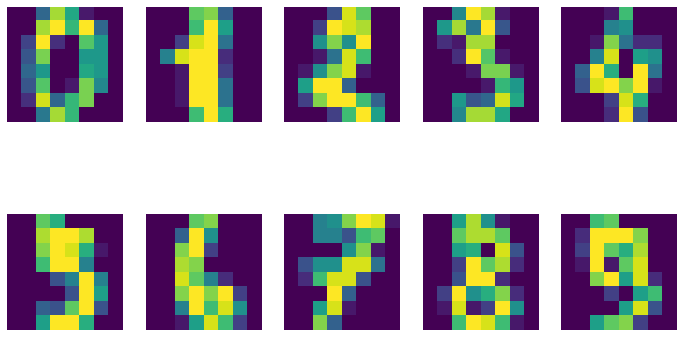

In [5]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
for ax, image in zip(axes.flatten(), X):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=SEED):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.objective = []
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        distance = np.zeros((X.shape[0], cluster_centers.shape[0]))
        
        return pairwise_distances(X, cluster_centers, metric='euclidean')
        
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""

        new_centers = np.ones((self.n_clusters, X.shape[1]))

        for i in range(self.n_clusters):
            mask = nearest_clusters[:,i] == nearest_clusters.min(axis=1)
            new_centers[i] = X[mask].mean(axis=0)

        return new_centers
        
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        centroids_old = np.zeros((self.n_clusters, X.shape[1]))

        sum_error = 10000
        sum_error_old = 10000
        for iter in range(self.n_init):
            for i in range(self.n_clusters):
                row = self.random_state.choice(X.shape[0])
                centroids[i] = X[row]

            objective = []
            reapet = 0
            for i in range(self.max_iter):
                clusters = self.calculate_distances_to_centroids(X, centroids)
                centroids = self.update_centroids(X, clusters)
                to_minimize = self.calculate_distances_to_centroids(X, centroids)
                # если повторяется objective функция более n раз, то прекращаем выполнение
                # if np.linalg.norm(np.min(to_minimize, axis=1)) == sum_error:
                #     reapet += 1
                #     if reapet > 5:
                #         break
                sum_error = np.linalg.norm(np.min(to_minimize, axis=1))
                objective.append(sum_error**2)

            if self.n_init > 1:
                self.objective.append(objective)  
            else:
                self.objective = objective
            if iter == 0:
                centroids_old = centroids
                sum_error_old = sum_error
              
            if iter > 0 and sum_error < sum_error_old:
                sum_error_old = sum_error
                centroids_old = centroids

        self.cluster_centers_ = centroids_old

        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            cluster_distance = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            clusters = np.argmin(cluster_distance, axis=1)
            return clusters
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

In [8]:
manual_kmean = CustomKMeans(n_clusters=10, n_init = 3, max_iter=150)
manual_kmean.fit(X);


**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

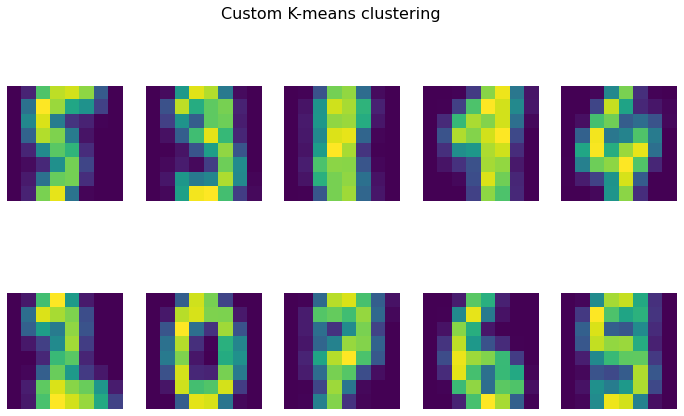

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('Custom K-means clustering', fontsize=16)
for ax, image in zip(axes.flatten(), manual_kmean.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

In [10]:
custom_kmeans_labels = manual_kmean.predict(X)
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

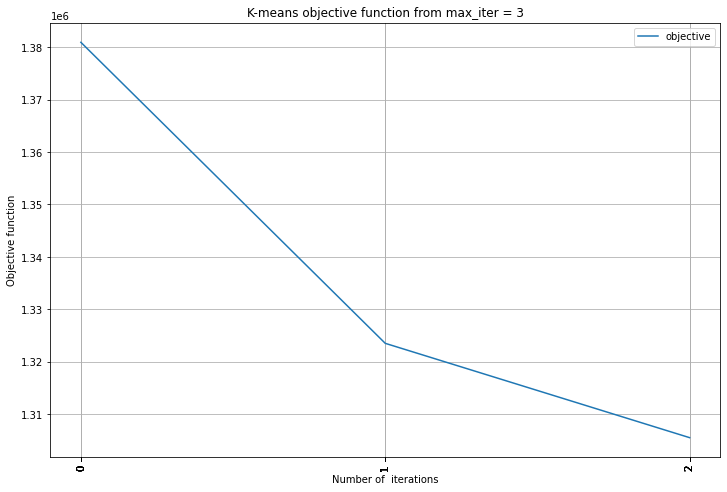

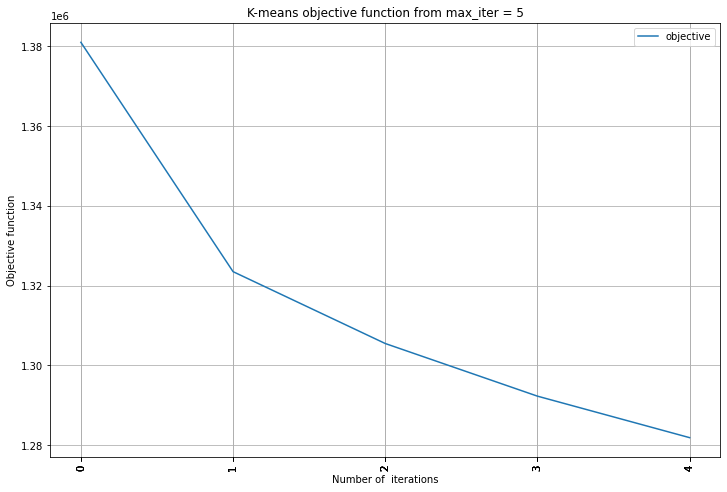

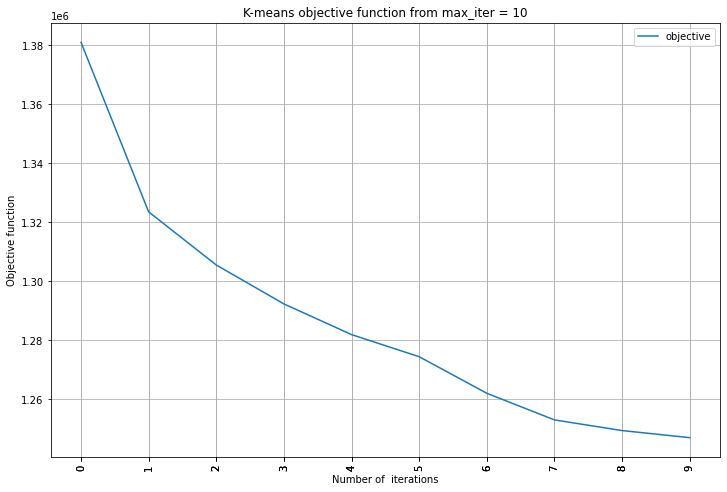

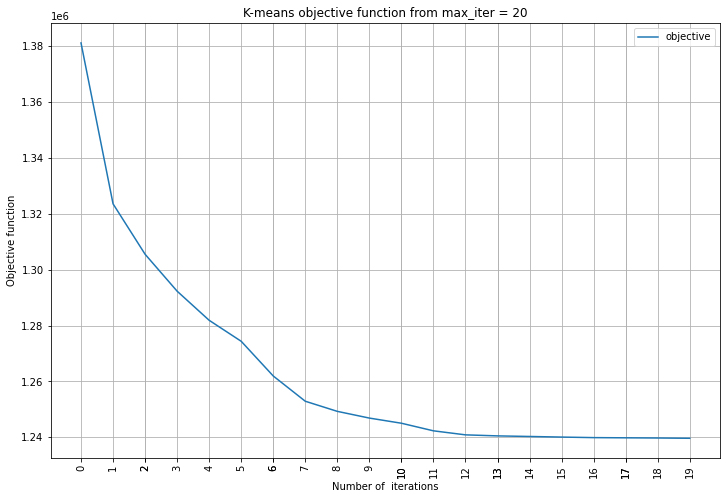

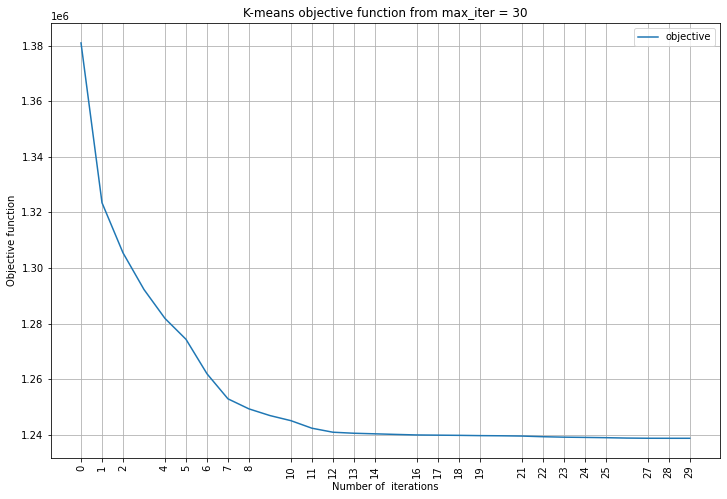

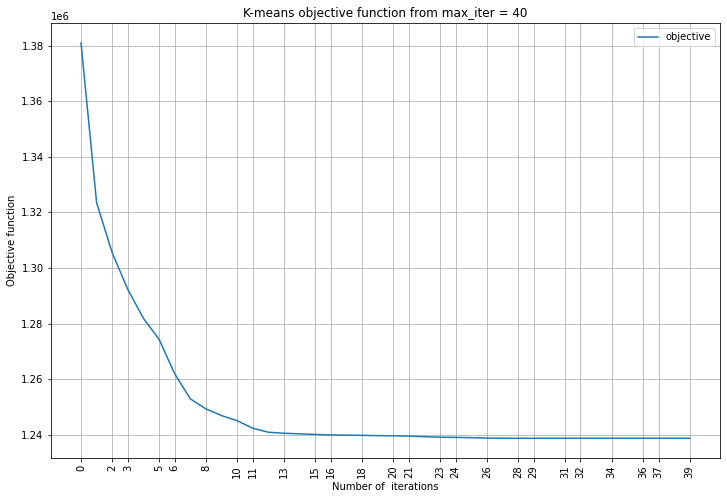

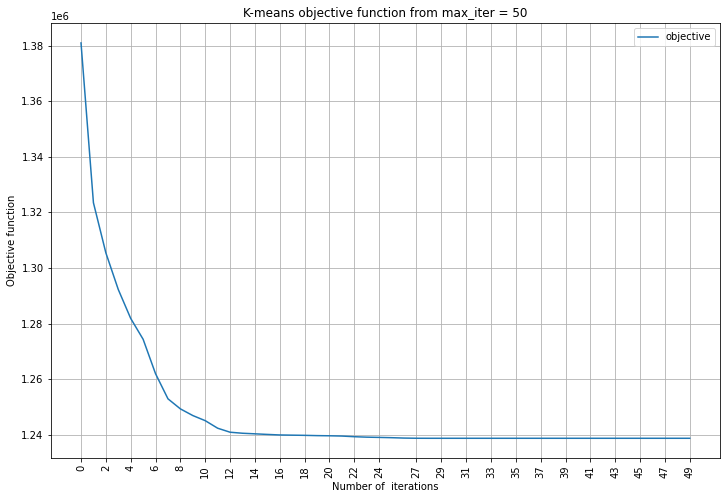

In [11]:
def plotting(model):
    iter = [*range(model.max_iter)]
    tick = np.around(np.linspace(0, model.max_iter-1, 25), decimals=0)
    objective = model.objective
    plt.figure(figsize=(12, 8))
    plt.ylabel("Objective function")
    plt.xlabel("Number of  iterations")
    plt.plot(iter, objective, label="objective")
    plt.grid(True)
    plt.xticks(tick, rotation='vertical')
    plt.legend(loc='best')    
    plt.title(f'K-means objective function from max_iter = {model.max_iter}')
    plt.show()

list_iter = [3, 5, 10, 20, 30, 40, 50]
best_objective_iter = []
for max_iter in list_iter:
    manual_kmean = CustomKMeans(n_clusters=10, n_init = 1, max_iter=max_iter)
    manual_kmean.fit(X);
    best_objective_iter.append(np.min(manual_kmean.objective))
    plotting(manual_kmean)

In [12]:
print("Лучшие значения с увеличением числа итераций и 1 инициализацией:\n")
for i, v in enumerate(best_objective_iter):
    print(f"\t\t\033[1m{list_iter[i]} инициализаций\033[0m :",end="\t\t")
    print(f"Минимум {v} на {list_iter[i]} итерации \n")
    # print('\n')
print(f"Самое минимальное значение objective функции {np.min(best_objective_iter)}")

Лучшие значения с увеличением числа итераций и 1 инициализацией:

		3 инициализаций :		Минимум 1305464.7415082422 на 3 итерации 

		5 инициализаций :		Минимум 1281862.7444066815 на 5 итерации 

		10 инициализаций :		Минимум 1246921.7948866284 на 10 итерации 

		20 инициализаций :		Минимум 1239703.608257402 на 20 итерации 

		30 инициализаций :		Минимум 1238746.5801602374 на 30 итерации 

		40 инициализаций :		Минимум 1238746.5801602374 на 40 итерации 

		50 инициализаций :		Минимум 1238746.5801602374 на 50 итерации 

Самое минимальное значение objective функции 1238746.5801602374


**Вывод**

Из графиков видно, что при одной начальной инициализации, значения objective функции падают с увеличением количества итераций до определенного уровня, но потом доходят до некого минимума и не изменяются при дальнейшем увеличении повторений. Предположительно центры кластеров доходят до некого "идеального" значения и дальнейшее уменьшение расстояний от центров кластеров до своих точек не наблюдается. Следовательно значение objective функции не уменьшаются. 

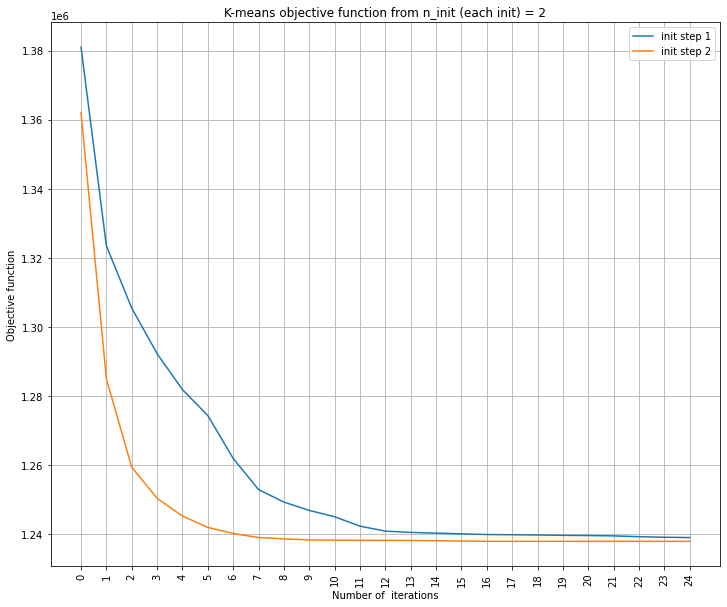

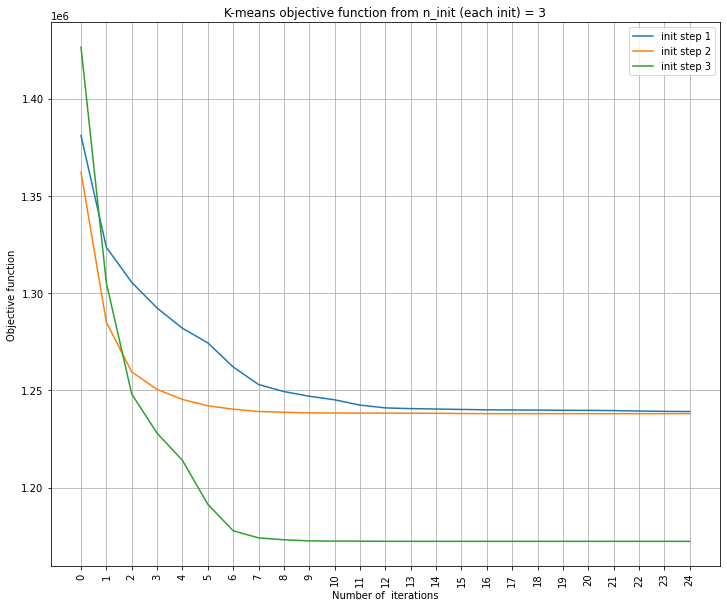

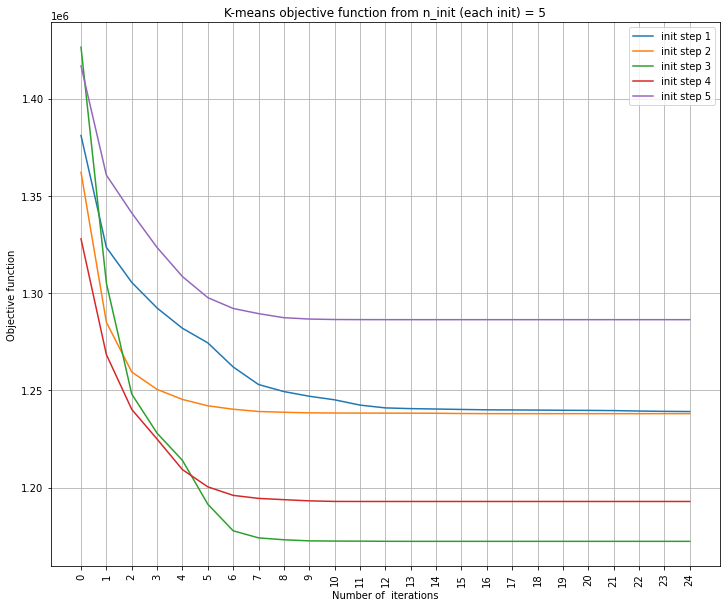

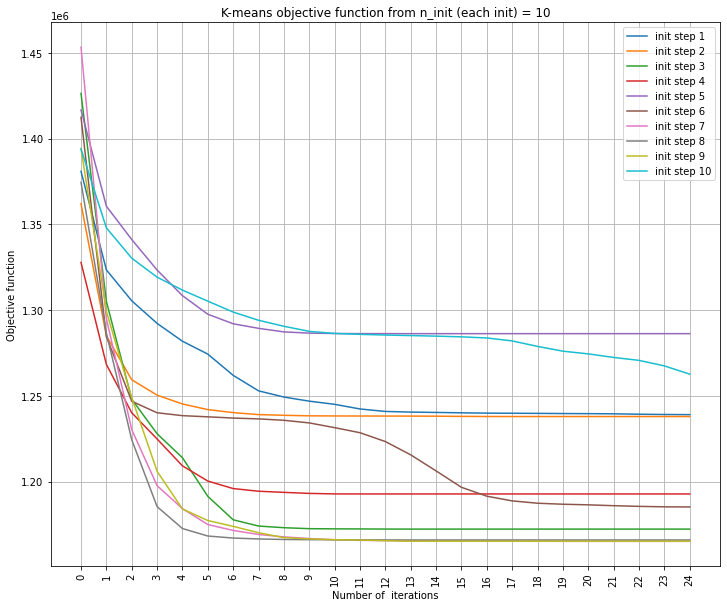

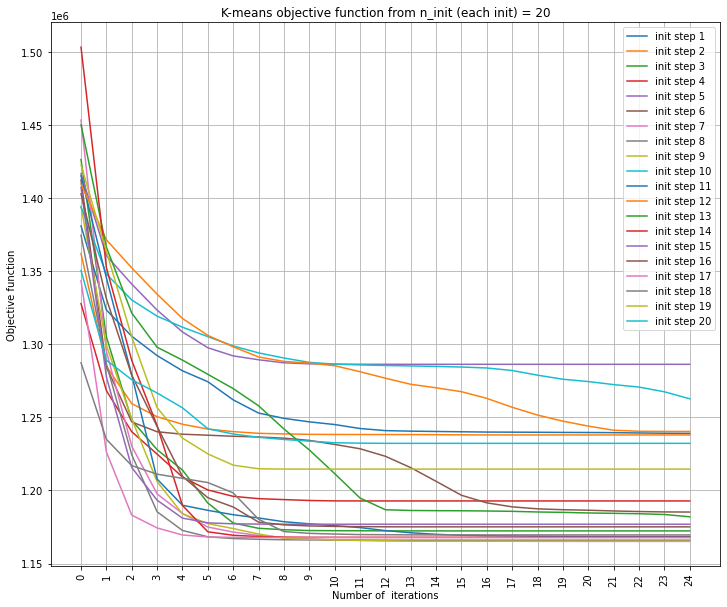

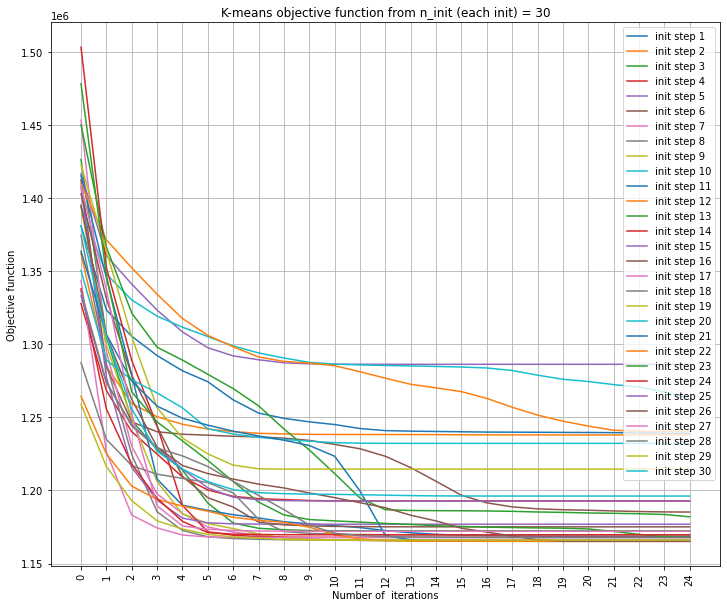

In [13]:
def plotting(model):
    iter = [*range(model.max_iter)]
    tick = np.around(np.linspace(0, model.max_iter-1, 25), decimals=0)
    objective = model.objective
    plt.figure(figsize=(12, 10))
    if isinstance(objective[0], list): 

        for i, v in enumerate(model.objective):
            objective[i] = v      
        plt.ylabel("Objective function")
        plt.xlabel("Number of  iterations")

        for i, object in enumerate(objective):
            plt.plot(iter, object, label=f"init step {i+1}")
    else:
        plt.plot(iter, objective, label=f"init step 1")
        plt.ylabel("Objective function")
        plt.xlabel("Number of  iterations")

    plt.xticks(tick, rotation='vertical')
    plt.legend(loc='best')    
    plt.grid(True)
    plt.title(f'K-means objective function from n_init (each init) = {model.n_init}')
    plt.show()


list_init = [2, 3, 5, 10, 20, 30]
best_objective_init = []
for n_init in list_init:
    manual_kmean = CustomKMeans(n_clusters=10, n_init = n_init, max_iter=25)
    manual_kmean.fit(X);
    best_objective_init.append(manual_kmean.objective)
    plotting(manual_kmean)


In [14]:
print("Лучшие значение с увеличение числа инициализаций:\n")
for e in best_objective_init:
    print(f"\t\t\033[1m{len(e)} инициализаций\033[0m :",end="\t\t")
    print(f"Минимум {np.min(e)} на {np.argmin(np.min(e, axis=1))+1} инициализации \n")
    # print('\n')
print(f"Самое минимальное значение objective функции {np.min(e)}")

Лучшие значение с увеличение числа инициализаций:

		2 инициализаций :		Минимум 1237969.703271979 на 2 инициализации 

		3 инициализаций :		Минимум 1172321.7387749928 на 3 инициализации 

		5 инициализаций :		Минимум 1172321.7387749928 на 3 инициализации 

		10 инициализаций :		Минимум 1165180.5352550172 на 7 инициализации 

		20 инициализаций :		Минимум 1165180.5352550172 на 7 инициализации 

		30 инициализаций :		Минимум 1165177.956424017 на 22 инициализации 

Самое минимальное значение objective функции 1165177.956424017


**Вывод**

Из графиков видно, что при зафиксированном количестве итераций, с увеличением числа инициализаций, минимальное значение objective функции снижается. Отдельные инициализации попадают в локальные минимумы и показываеют высокие значения objective функции, но лучшие значения снижаются, но тоже не ниже определенной величины. Следовательно можно сделать вывод, что для того чтобы уменьшить значение objective функции, то нужно увеличивать количество инициализаций и количество итераций. Но, само собой, в разумных пределах.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Иерархической кластеризация
ag_clustering = AgglomerativeClustering(n_clusters=10).fit(X)
# ag_clustering.labels_
n_clusters = ag_clustering.get_params()['n_clusters']
# ag_clustering.labels_

# Находим центры класстеров для иерархической кластеризации
ag_centers = np.ones((n_clusters, X.shape[1]))
for i in range(n_clusters):
    mask = ag_clustering.labels_ == i
    ag_centers[i] = X[mask].mean(axis=0)

# K-means кластеризация
k_clustering = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=3).fit(X)

In [16]:
hierarchical_labels = ag_clustering.labels_
kmeans_labels = k_clustering.labels_

In [17]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

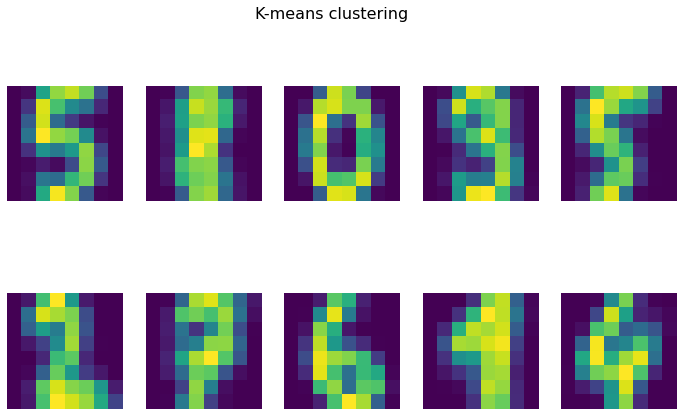

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('K-means clustering', fontsize=16)
for ax, image in zip(axes.flatten(), k_clustering.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

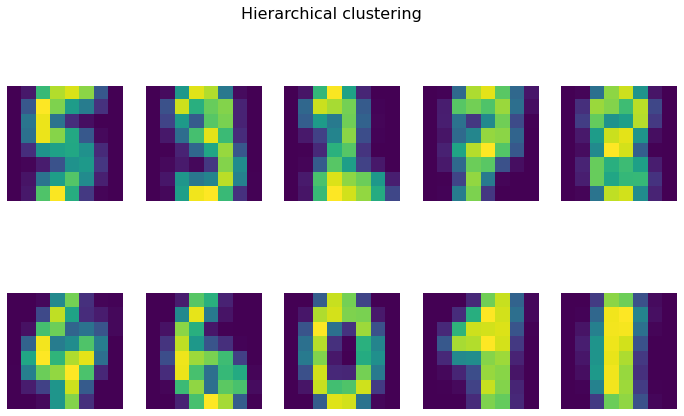

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('Hierarchical clustering', fontsize=16)
for ax, image in zip(axes.flatten(), ag_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(1 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [20]:
from sklearn.metrics import silhouette_score
silhouette_k = []
silhouette_ag = []
for i in range(2, 21):
    k_clustering = KMeans(n_clusters=i, random_state=SEED, max_iter=100, n_init=3).fit(X)
    silhouette_k.append(silhouette_score(X, k_clustering.labels_, metric='euclidean'))

    ag_clustering = AgglomerativeClustering(n_clusters=i).fit(X)
    silhouette_ag.append(silhouette_score(X, ag_clustering.labels_, metric='euclidean'))
    

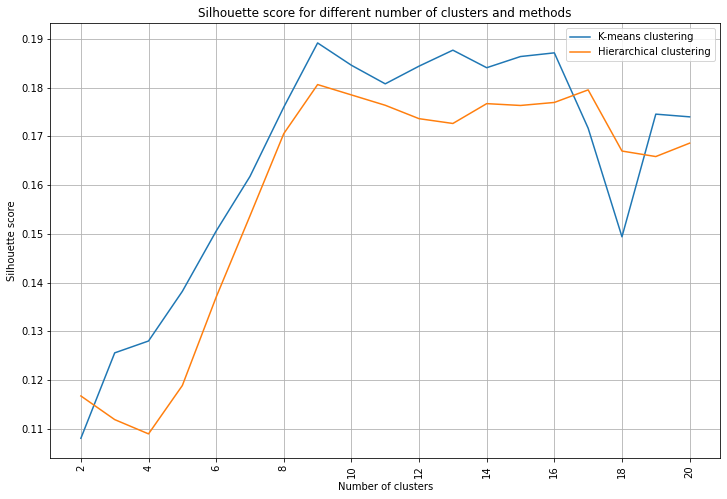

In [21]:
def plotting(score_k, score_ag, title, step=10, label_x='X', label_y='Y', start=0):
    iter = [*range(start, len(score_k)+start)]
    tick = np.around(np.linspace(start, iter[-1], step), decimals=0)
    plt.figure(figsize=(12, 8))
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    plt.plot(iter, score_k, label="K-means clustering")
    plt.plot(iter, score_ag, label="Hierarchical clustering")
    plt.grid(True)
    plt.xticks(tick, rotation='vertical')
    plt.legend(loc='best')    
    plt.title(title)
    plt.show()

title = 'Silhouette score for different number of clusters and methods'
label_x = "Number of clusters"
label_y = "Silhouette score"
plotting(silhouette_k, silhouette_ag, title=title, label_x=label_x, label_y=label_y, start=2)

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [22]:
from sklearn.metrics import v_measure_score
v_measure_k = []
v_measure_ag = []
for i in range(2, 21):
    k_clustering = KMeans(n_clusters=i, random_state=SEED, max_iter=100, n_init=3).fit(X)
    v_measure_k.append(v_measure_score(y, k_clustering.labels_))

    ag_clustering = AgglomerativeClustering(n_clusters=i).fit(X)
    v_measure_ag.append(v_measure_score(y, ag_clustering.labels_))

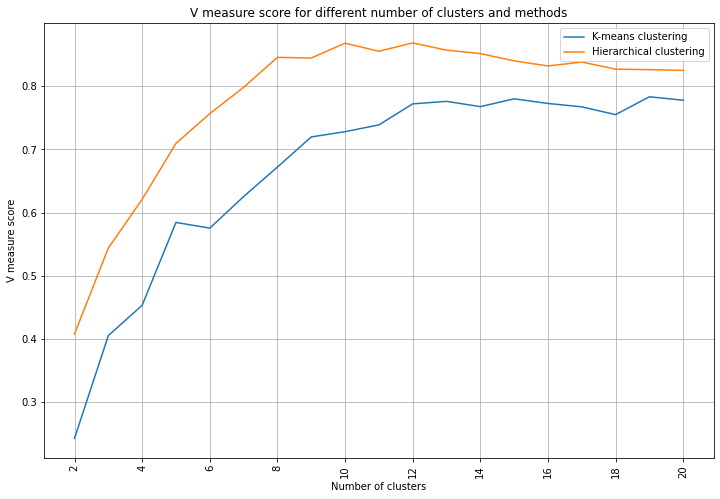

In [23]:
title = 'V measure score for different number of clusters and methods'
label_x = "Number of clusters"
label_y = "V measure score"
# plotting(v_measure_k, v_measure_ag,step=20, title=title, label_x=label_x, label_y=label_y, start=2)
plotting(v_measure_k, v_measure_ag, title=title, label_x=label_x, label_y=label_y, start=2)

In [24]:
print("Наибольшие значения для Silhouette score и V measure score:\n")
print('\t\033[1mSilhouette score\033[0m :')
print(f"\t\t для K-means : \t\t\t{np.max(silhouette_k)} на {np.argmax(silhouette_k) + 2} кластерах")
print(f"\t\t для AgglomerativeClustering : {np.max(silhouette_ag)} на {np.argmax(silhouette_ag) + 2} кластерах \n")
print('\t\033[1mV measure score\033[0m :')
print(f"\t\t для K-means : \t\t\t{np.max(v_measure_k)} на {np.argmax(v_measure_k) + 2} кластерах")
print(f"\t\t для AgglomerativeClustering : {np.max(v_measure_ag)} на {np.argmax(v_measure_ag) + 2} кластерах\n")

print(f"Для примера AgglomerativeClustering : {v_measure_ag[8]} на 10 кластерах \n")


Наибольшие значения для Silhouette score и V measure score:

	Silhouette score :
		 для K-means : 			0.18916206558390755 на 9 кластерах
		 для AgglomerativeClustering : 0.18061975703867697 на 9 кластерах 

	V measure score :
		 для K-means : 			0.7833882405825552 на 19 кластерах
		 для AgglomerativeClustering : 0.86854875186737 на 12 кластерах

Для примера AgglomerativeClustering : 0.8681701126909083 на 10 кластерах 



**Вывод**

Выведены зависимости V measure score и Silhouette score от числа кластеров, на которые группируются наши данные. Графики построены для Иерархической (Агломеративные) и K-means типов кластеризации.


*   На графике Silhouette score, метод K-means показывает более высокие значения, нежели Агломеративные, почти на всех количествах кластеров. Но в целом значения "силуэта" низкие, что может означать, что границы кластреров находятся близко друг к  другу или даже перекрываются. Максимум Silhouette score получается при количестве кластеров равном 9.
*   На графике V measure score, Агломеративный метод показывает более хорошие результаты, чем K-means. Максимум V score достигается при количестве кластеров равном 12. Хотя значение при 10 тоже неплохие. Значения V score достаточно близки к 1. 



## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(1 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [25]:
from sklearn.decomposition import TruncatedSVD

# Посчитаем SVD разложение на необходимое количество признаков
svd_dec = []
n_features = [*range(2, 31)]
for n_feature in n_features:
    svd = TruncatedSVD(n_components=n_feature, n_iter=7, random_state=SEED)
    svd.fit(X)
    svd_dec.append(svd.transform(X))

In [26]:
silhouette_svd_k = []
silhouette_svd_ag = []
for i, data in enumerate(svd_dec):
    k_clustering = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=3).fit(data)
    silhouette_svd_k.append(silhouette_score(X, k_clustering.labels_, metric='euclidean'))

    ag_clustering = AgglomerativeClustering(n_clusters=10).fit(data)
    silhouette_svd_ag.append(silhouette_score(X, ag_clustering.labels_, metric='euclidean'))

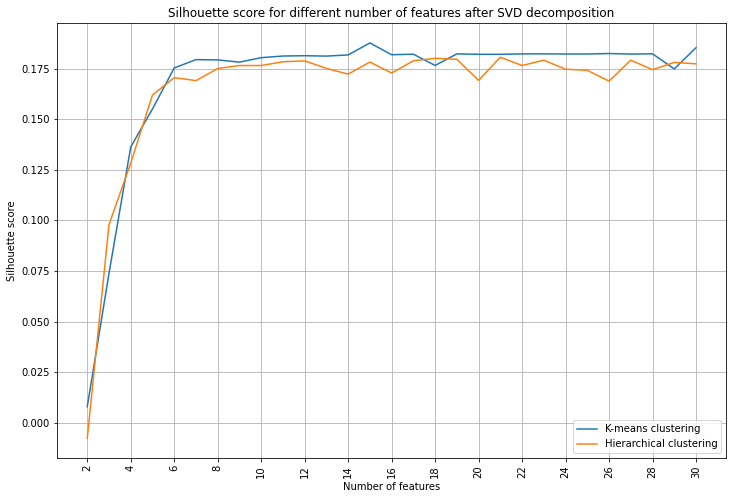

In [27]:
title = 'Silhouette score for different number of features after SVD decomposition'
label_x = "Number of features"
label_y = "Silhouette score"
plotting(silhouette_svd_k, silhouette_svd_ag, step=15, title=title, label_x=label_x, label_y=label_y, start=2)

In [28]:
v_measure_svd_k = []
v_measure_svd_ag = []
for i, data in enumerate(svd_dec):
    k_clustering = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=3).fit(data)
    v_measure_svd_k.append(v_measure_score(y, k_clustering.labels_))

    ag_clustering = AgglomerativeClustering(n_clusters=10).fit(data)
    v_measure_svd_ag.append(v_measure_score(y, ag_clustering.labels_))

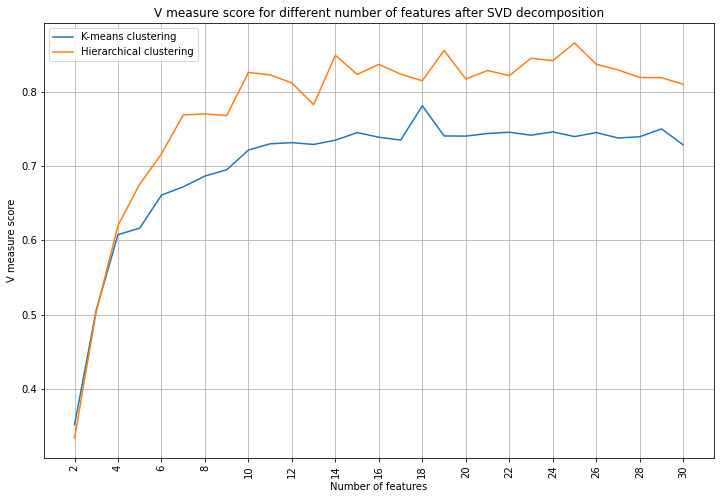

In [29]:
title = 'V measure score for different number of features after SVD decomposition'
label_x = "Number of features"
label_y = "V measure score"
plotting(v_measure_svd_k, v_measure_svd_ag, step=15, title=title, label_x=label_x, label_y=label_y, start=2)

In [66]:
print("Наибольшие значения для Silhouette score и V measure score после SVD преобразования:\n")
print('\t\033[1mSilhouette score\033[0m :')
print(f"\t\t для K-means : {np.max(silhouette_svd_k)} при {np.argmax(silhouette_svd_k) + 2} признаках")
print(f"\t\t для AgglomerativeClustering : {np.max(silhouette_svd_ag)} при {np.argmax(silhouette_svd_ag) + 2} признаках \n")
print('\t\033[1mV measure score\033[0m :')
print(f"\t\t для K-means : {np.max(v_measure_svd_k)} при {np.argmax(v_measure_svd_k) + 2} признаках")
print(f"\t\t для AgglomerativeClustering : {np.max(v_measure_svd_ag)} при {np.argmax(v_measure_svd_ag) + 2} признаках\n")

print(f"V measure score для AgglomerativeClustering : {np.max(v_measure_ag)} до SVD преобразования признаков.")
print(f"Silhouette score для AgglomerativeClustering : {np.max(silhouette_ag)} до SVD преобразования признаков.")


Наибольшие значения для Silhouette score и V measure score после SVD преобразования:

	Silhouette score :
		 для K-means : 0.18775321013544338 при 15 признаках
		 для AgglomerativeClustering : 0.18066735651283333 при 21 признаках 

	V measure score :
		 для K-means : 0.7810831317923815 при 18 признаках
		 для AgglomerativeClustering : 0.8656699028924201 при 25 признаках

V measure score для AgglomerativeClustering : 0.86854875186737 до SVD преобразования признаков.
Silhouette score для AgglomerativeClustering : 0.18061975703867697 до SVD преобразования признаков.


**Вывод**

Произведено SVD преобразование наших данных, с последующей кластеризацией и вычислением метрик. Так как использовался метов TruncatedSVD, то данные не центрировались, так как этот метод может работать с нецентрированными данными.

Выведены зависимости V measure score и Silhouette score от количества размерностей после SVD преобразования. Графики построены для Иерархической (Агломеративные) и K-means типов кластеризации.



*   Видно, что Silhouette score для обоих методов кластеризации вышел на плато примерно к 7-8 признакам. Значения низкие, близкие к нулю. K-means кластеризация показывает чуть более высокие значения, чем Агломеративная.
*   Значения V score перестают значимо расти где то к 14 признакам. Значения близки к 1. В этой метрике наоборот, Агломеративная кластеризация показывает более высокие значения, чем K-means клстеризация.

Значения признаков получаем почти как до SVD преобразования. Максимумы метрик выведены в ячейке выше.



Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [70]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=SEED, perplexity=40).fit_transform(X)


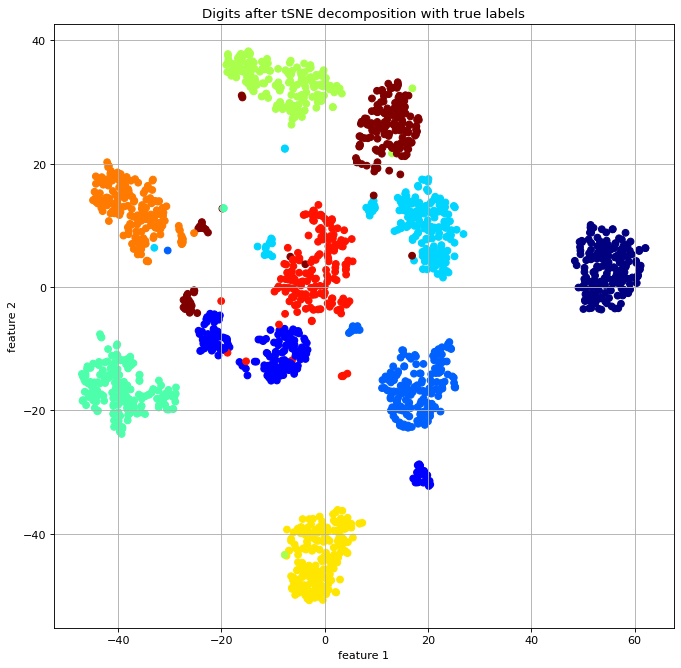

In [71]:
x_tsne = X_tsne[:, 0]
y_tsne = X_tsne[:, 1]

plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after tSNE decomposition with true labels')
plt.scatter(x_tsne, y_tsne, c=y, cmap="jet")

plt.show()


**Вывод**

После tSNE преобразования наших данных до 2 признаков, выведен график, где цветом показано настоящий класс цифр. Видно, что после преобразования, данные достаточно хорошо сгруппированы по группам, но некоторые данные попали в другие места (точки другого цвета внутри групп). Видимо в исходном признаковом пространстве эти точки ближе не к своим кластерам по ряду признаков, и в результате нелинейного tSNE преобразования, были перенесены в подобные места в двумерном признаковом пространстве.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [ ]:
k_tsne_clustering = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=3).fit(X_tsne)
ag_tsne_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tsne)

In [81]:
# Центры класстеров для К means кластеризации
k_centers_tsne = k_tsne_clustering.cluster_centers_

# Находим центры класстеров для иерархической кластеризации
n_clusters = 10
ag_centers_tsne = np.ones((n_clusters, X_tsne.shape[1]))
for i in range(n_clusters):
    mask = ag_tsne_clustering.labels_ == i
    ag_centers_tsne[i] = X_tsne[mask].mean(axis=0)

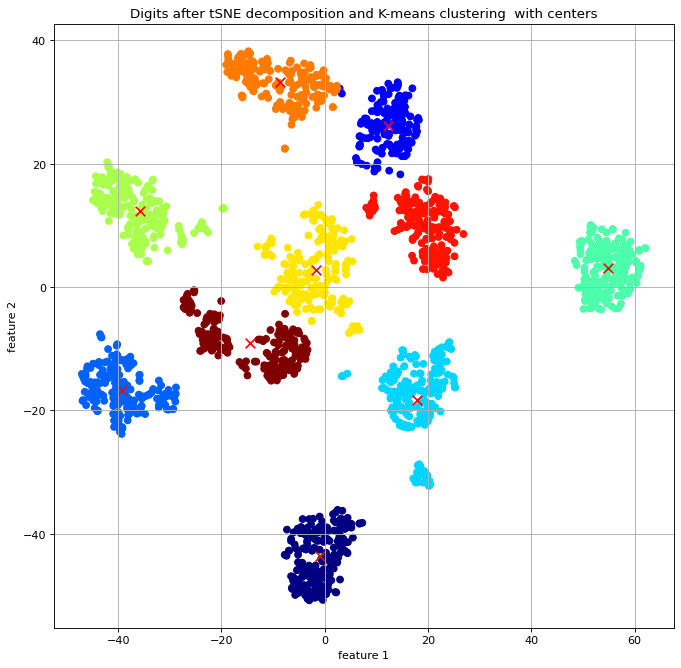

In [77]:
plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after tSNE decomposition and K-means clustering  with centers')
plt.scatter(x_tsne, y_tsne, c=k_clustering.labels_, cmap="jet")
plt.scatter(k_centers_tsne[ : , 0], k_centers_tsne[ : , 1], c='red', marker='x', s= 75)
plt.show()

# Красные кресты обозначают центры кластеров

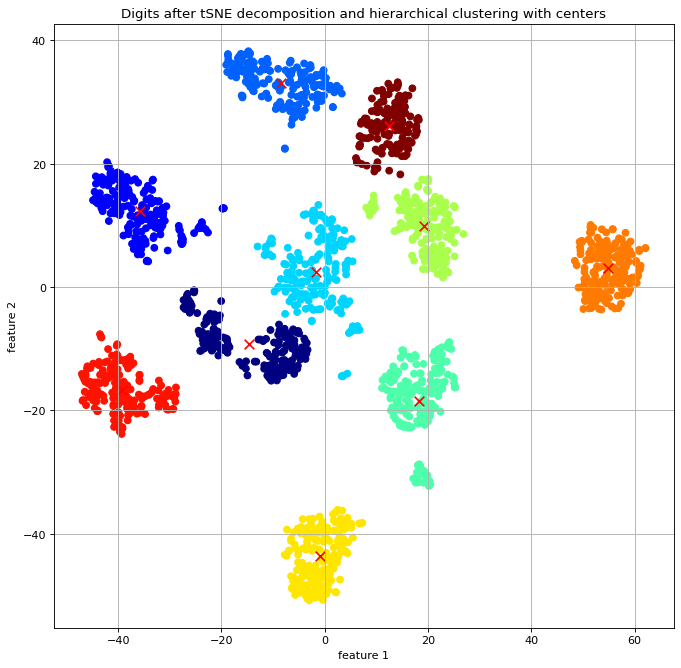

In [82]:
plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after tSNE decomposition and hierarchical clustering with centers')
plt.scatter(x_tsne, y_tsne, c=ag_tsne_clustering.labels_, cmap="jet")
plt.scatter(ag_centers_tsne[ : , 0], ag_centers_tsne[ : , 1], c='red', marker='x', s=75)
plt.show()

In [83]:

print("Значения для Silhouette score и V measure score после tSNE преобразования:\n")
print('\t\033[1mSilhouette score\033[0m (tSNE) :')
print(f"\t\t для K-means :\t\t\t{silhouette_score(X, k_tsne_clustering.labels_, metric='euclidean')}")
print(f"\t\t для AgglomerativeClustering : {silhouette_score(X, ag_tsne_clustering.labels_, metric='euclidean')}\n")
print('\t\033[1mV measure score\033[0m (tSNE) :')
print(f"\t\t для K-means :\t\t\t{v_measure_score(y, k_tsne_clustering.labels_)}")
print(f"\t\t для AgglomerativeClustering : {v_measure_score(y, ag_tsne_clustering.labels_)}\n")

print("Значения для Silhouette score и V measure score для оригинальных данных и том же количестве кластеров:\n")
print('\t\033[1mSilhouette score\033[0m (original) :')
print(f"\t\t для K-means : \t\t\t{silhouette_k[8]}")
print(f"\t\t для AgglomerativeClustering : {silhouette_ag[8]}")
print('\t\033[1mV measure score\033[0m (original) :')
print(f"\t\t для K-means : \t\t\t{v_measure_k[8]}")
print(f"\t\t для AgglomerativeClustering : {v_measure_ag[8]}")

Значения для Silhouette score и V measure score после tSNE преобразования:

	Silhouette score (tSNE) :
		 для K-means :			0.164080332378932
		 для AgglomerativeClustering : 0.16375947486571418

	V measure score (tSNE) :
		 для K-means :			0.9020541300320866
		 для AgglomerativeClustering : 0.909384579346888

Значения для Silhouette score и V measure score для оригинальных данных и том же количестве кластеров:

	Silhouette score (original) :
		 для K-means : 			0.18457956537996656
		 для AgglomerativeClustering : 0.17849659940596496
	V measure score (original) :
		 для K-means : 			0.7281878857508839
		 для AgglomerativeClustering : 0.8681701126909083


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

**Вывод**

Построены рафики для двух методов кластеризации (Иерархическая и K-means). Красными крестами обозначены центры кластеров, найденые соответсвующими алгортмами кластеризации. Дополнительно посчитаны метрики V measure score и Silhouette score для кластеризации данных после tSNE преобразования, также выведены метрики для непреобразованных данных.

Так как максимальное значение V-score = 0.909384579346888, то выбран Иерархический метод кластеризации для данных после tSNE преобразования с числом кластеров равным 10.

In [88]:
# k_clustering = KMeans(n_clusters=10, random_state=SEED, max_iter=30, n_init=2).fit(X_tsne)
ag_cluster_end = AgglomerativeClustering(n_clusters=10).fit(X_tsne)

# Находим центры класстеров для K-means кластеризации

n_clusters = 10
kmeans_centers = np.ones((n_clusters, X.shape[1]))
kmeans_centers1 = np.ones((n_clusters, X.shape[1]))
kmeans_centers2 = np.ones((n_clusters, X.shape[1]))
for i in range(n_clusters):
    mask = ag_cluster_end.labels_ == i
    kmeans_centers[i] = X[mask].mean(axis=0)
    kmeans_centers1[i] = np.median(X[mask], axis=0)
    

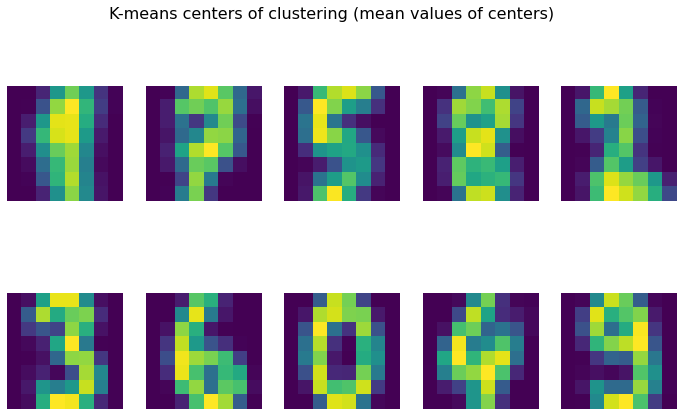

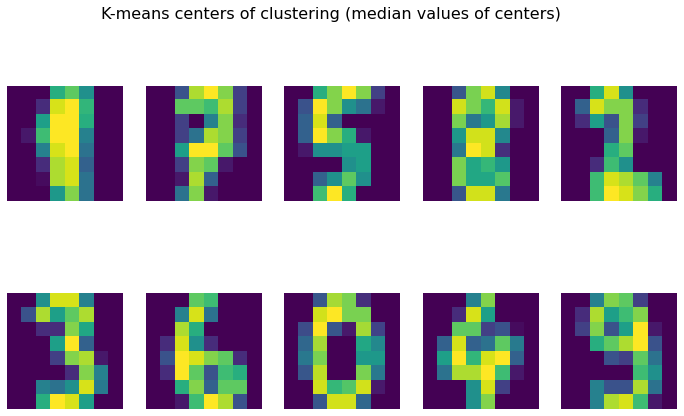

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('K-means centers of clustering (mean values of centers)', fontsize=16)
for ax, image in zip(axes.flatten(), kmeans_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('K-means centers of clustering (median values of centers)', fontsize=16)
for ax, image in zip(axes.flatten(), kmeans_centers1):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))

Выведены центры Агломеративной кластеризации усредненные средним значением(сверху) и медианой(снизу). В результате кластеризации получаем вполне различимые отдельные цифры. Кластеризация первоначальных данных без дополнительных преобразований такого эффекта не давала. Часть цифр плохо читалась. Например 8 и 9 или 5 и 9.

Было сделано:

*   Реализована кластеризация методом K-means. Построенны графики зависимости objective функции от количества итераций, а так же от количества начальных иницицализаций центров класстеров. Выведены центры кластеров найденых методами  K-means(написанном самостоятельно) и иерархической кластеризацией. 
*   Построенны графики зависимости метрик V measure score и Silhouette score от количества кластеров для методов K-means и иерархической кластеризации. Здесь и далее использованы библиотечные методы
*   Произведено SVD преобразования наших данных. Построены графики завасимости метрик V score и Silhouette score от размера пространства признаков после преобразования.
*   Произведено tSNE преобразование признаков в двумерное пространство. Выведены данные после преобразования с раскрашеные в соответсвии с оригинальными данными. Произведена кластеризация двумя методами, построены графики данных раскрашенные в соответствии с кластеризацией. Так же посчитаны метрики и на их основе выбран метод, для которого, после кластеризации, выведены центры кластеров. На основе значений V score выбрана иерархическая (агломеративная) кластеризация. Цифры неплохо различимы, по сравнению с центрами кластеризации на первоначальных данных.

Более подробные выводы написаны под каждым пунктом.



## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Как уже написано выше, в данной работе был выбрано метод аггломеративной кластеризации. Выбор сделан на основе значений V score, так как Silhouette score давал низкие значения. Думаю, что качество кластеризации зависит от самих данных( например K-means лучше кластеризует данные собранные в шары, ну то есть точки плюс минус равно удалены от центра), настроек алгоритма и от выбранной метрики.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.



1.   Можно использовать классификатор поверх полученных кластеризованных данных. Например KNN.
2.   Так же прочитал, что можно понизить размерность кластеризованных данных с помощью РСА до одной компоненты и использовать ее как класификатор. 
Качество можно наверно мерять эвклидовой метрикой расстояния котороя выступает некой мерой подобия.




**(0.5 points)** Does dimensionality reduction improve clustering results?

Понижение размерности полезно при кластеризации, особенно когда данные с большим количеством признаков. По мере добавления дополнительных признаков данные становятся разряженными. Есть такое понятие как "проклятие размерности". Так вот, уменьшение признакового пространства группирует данные более плотно, кроме того уменьшается вычислительная сложность.

**(0.5)** How to evaluate the quality of dimensional reducrion? Suggest at least 2 options.



1.   Думаю путем измерения расстояния между набором удаленных точек, с последующим сравнением этих расстояний, с расстояний между ними в новом признаковом пространстве.
2.   Ранжирование данных по MSE с последующим восстановлением размерности и проведением такой же процедуры для новых данных.



**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [90]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [91]:
X_mnist = np.asarray(X_mnist)
y_mnist = np.asarray(y_mnist)

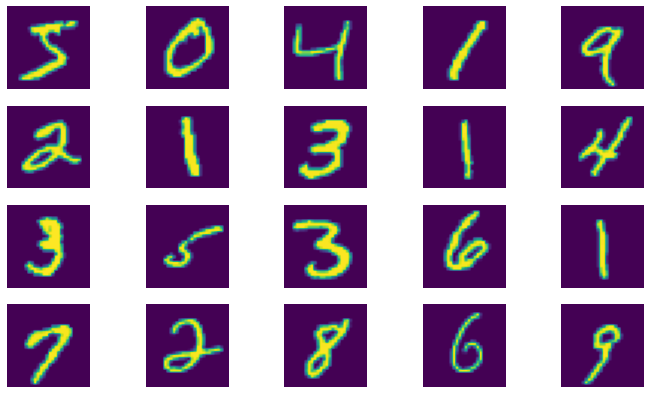

In [93]:
_, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 7))
for ax, image in zip(axes.flatten(), X_mnist):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))


In [103]:
# Так как данных у нас 70000, отделим кусок для задания, так как компьютер на справляется с полными данными

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.85, random_state=SEED)
X_train.shape


(10500, 784)

In [104]:
y_train = y_train.astype(np.int64)
y_train

array([4, 9, 5, ..., 1, 0, 0])

In [105]:
# Сразу сделаем tSNE преобразование, считал по данных без понижения размерности, V score низкий, плюс продлжительные вычисления.
X_mnist_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=SEED).fit_transform(X_train)


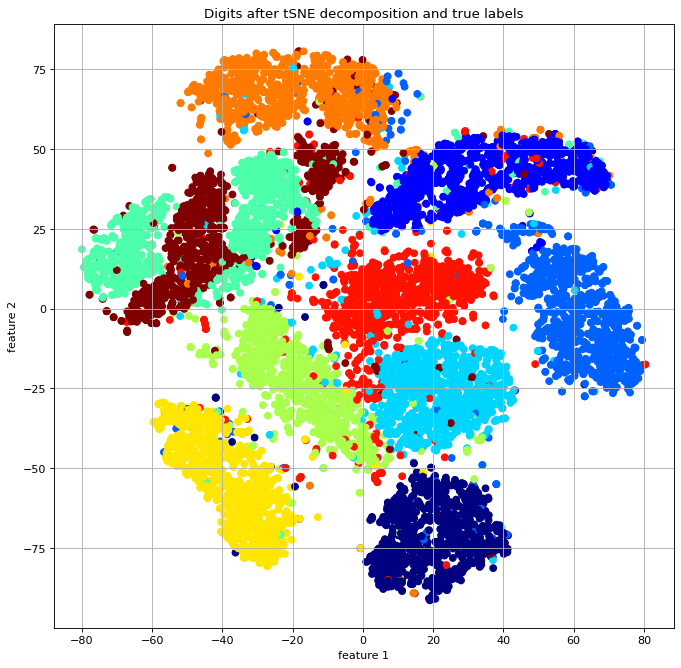

In [106]:
# Посмотрим как выглядят наши данные после tSNE с реальными метками.
x_tsne = X_mnist_tsne[:, 0]
y_tsne = X_mnist_tsne[:, 1]

plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after tSNE decomposition and true labels')
plt.scatter(x_tsne, y_tsne, c=y_train, cmap="jet")
plt.show()

In [107]:
# Кластеризируем наши данные

mnist_k = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=10).fit(X_mnist_tsne)

mnist_ag = AgglomerativeClustering(n_clusters=10).fit(X_mnist_tsne)


In [108]:
# Считаем V score

print('V measure score for K-means clustering of MNIST (tSNE) : ', v_measure_score(y_train, mnist_k.labels_))

print('V measure score for AgglomerativeClustering of MNIST (tSNE) : ', v_measure_score(y_train, mnist_ag.labels_))


V measure score for K-means clustering of MNIST (tSNE) :  0.7458052845652465
V measure score for AgglomerativeClustering of MNIST (tSNE) :  0.7852905929990729


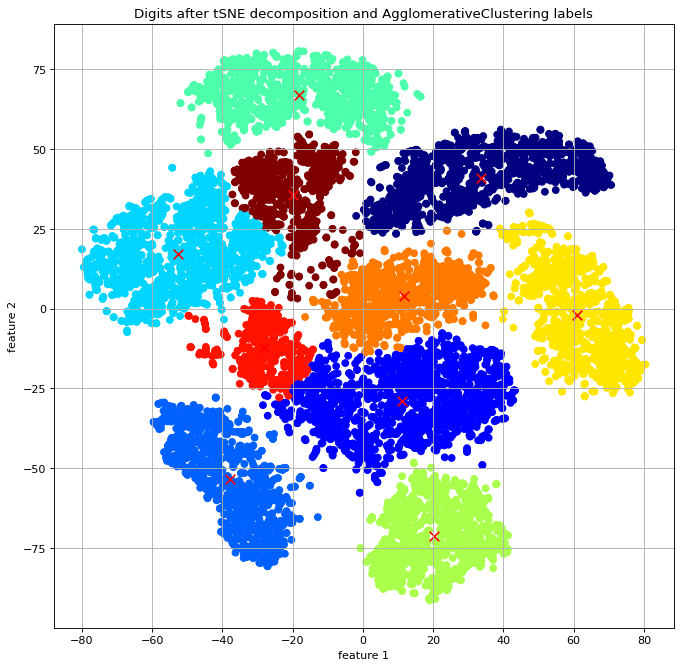

In [112]:
# выведем данные после кластеризации AgglomerativeClustering.

n_clusters = 10
mnist_centers = np.ones((n_clusters, X_mnist_tsne.shape[1]))
for i in range(n_clusters):
    mask = mnist_ag.labels_ == i
    mnist_centers[i] = np.mean(X_mnist_tsne[mask], axis=0)



plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after tSNE decomposition and AgglomerativeClustering labels')
plt.scatter(x_tsne, y_tsne, c=mnist_ag.labels_, cmap="jet")
plt.scatter(mnist_centers[ : , 0], mnist_centers[ : , 1], c='red', marker='x', s=75)
plt.show()
# Красные кресты помечают центры кластеров

In [109]:
# выбираем AgglomerativeClustering 0.7852905929990729

# усредняем наши центры для отображения.
n_clusters = 10
mnist_k_centers = np.ones((n_clusters, X_train.shape[1]))
for i in range(n_clusters):
    mask = mnist_ag.labels_ == i
    mnist_k_centers[i] = np.mean(X_train[mask], axis=0)

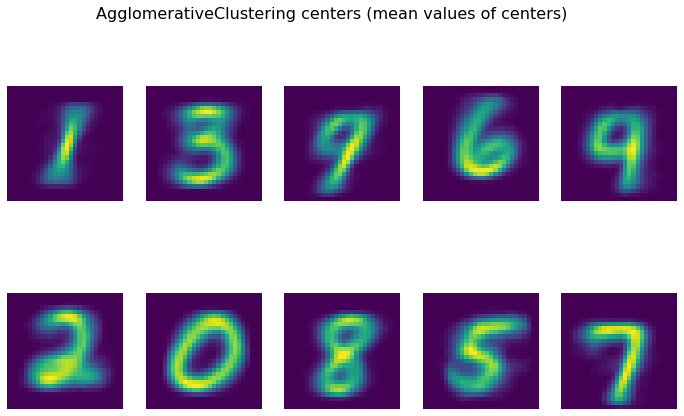

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('AgglomerativeClustering centers (mean values of centers)', fontsize=16)
for ax, image in zip(axes.flatten(), mnist_k_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))

In [52]:
# !pip install -e git+https://github.com/lmcinnes/umap.git@0.4dev#egg=umap4 

In [53]:
# !pip install /content/src/umap4

In [54]:
import umap

In [55]:


umap_mnist = umap.UMAP(n_components=2,
                       random_state=SEED,
                    #    min_dist=0.3,
                    #    n_neighbors=5,
                       metric='correlation').fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


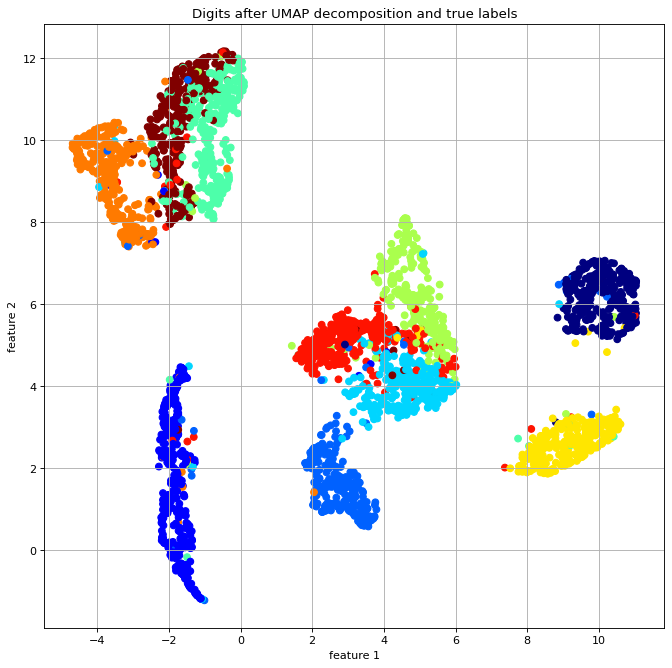

In [56]:
x_umap = umap_mnist[:, 0]
y_umap = umap_mnist[:, 1]

plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.grid(True)
plt.title('Digits after UMAP decomposition and true labels')
plt.scatter(x_umap, y_umap, c=y_train, cmap="jet")
# plt.scatter(ag_centers_tsne[ : , 0], ag_centers_tsne[ : , 1], c='red', marker='x')
plt.show()

In [57]:
# import umap
# sphere_mapper = umap.UMAP(output_metric='haversine', random_state=42, n_neighbors=50,min_dist=0.01).fit(pca)
umap_mnist.shape

(3500, 2)

In [58]:
mnist_k2 = KMeans(n_clusters=10, random_state=SEED, max_iter=50, n_init=10).fit(umap_mnist)
# mnist_k2 = KMeans(n_clusters=10, random_state=SEED, max_iter=100, n_init=10).fit(X_mnist_tsne1)
mnist_ag2 = AgglomerativeClustering(n_clusters=10).fit(umap_mnist)

In [59]:
print('V measure score for K-means clustering of MNIST (UMAP) : ', v_measure_score(y_train, mnist_k2.labels_))

print('V measure score for AgglomerativeClustering of MNIST (UMAP) : ', v_measure_score(y_train, mnist_ag2.labels_))

V measure score for K-means clustering of MNIST (UMAP) :  0.7617994950409045
V measure score for AgglomerativeClustering of MNIST (UMAP) :  0.807967732313981


In [60]:
n_clusters = 10
mnist_k_centers = np.ones((n_clusters, X_train.shape[1]))
for i in range(n_clusters):
    mask = mnist_ag2.labels_ == i
    mnist_k_centers[i] = np.mean(X_train[mask], axis=0)

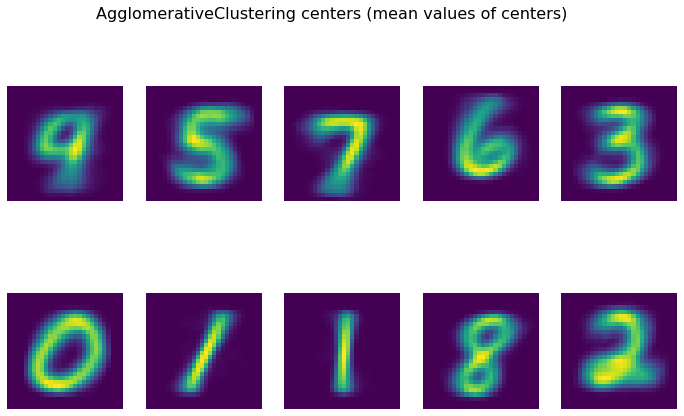

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 7))
fig.suptitle('AgglomerativeClustering centers (mean values of centers)', fontsize=16)
for ax, image in zip(axes.flatten(), mnist_k_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)))